In [ ]:
import geopandas as gpd

# --- Load data ---
gdf = gpd.read_file("/content/drive/MyDrive/data_set/merge/clean/feature_extraction/data_final.gpkg")


# Columns to group by (ignore fire and geometry)
group_cols = gdf.columns.difference(['fire', 'geometry'])

# Aggregate duplicates
gdf_clean = (
    gdf
    .groupby(list(group_cols), as_index=False)  # group by all features except fire & geometry
    .agg({'fire': 'max', 'geometry': 'first'})  # keep fire=1 if any, else 0; keep first geometry
)

# Print number of rows before and after
print("Total rows before resolving duplicates:", len(gdf))
print("Total rows after resolving duplicates:", len(gdf_clean))

# Replace original gdf
gdf = gdf_clean

import geopandas as gpd

# Convert back to GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs="EPSG:4326")  # use your actual CRS

# Save to GPKG
output_path = "/content/drive/MyDrive/training_fire/Decision Tree/data_final.gpkg"
gdf.to_file(output_path, driver="GPKG")


Total rows before resolving duplicates: 12248
Total rows after resolving duplicates: 11829


/usr/local/lib/python3.12/dist-packages/pyogrio/geopandas.py:382: UserWarning: More than one layer found in 'data_final.gpkg': 'final_data_final' (default), 'data_final'. Specify layer parameter to avoid this warning.
  result = read_func(


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters:
{'max_depth': 20, 'max_samples': None, 'n_estimators': 30}

=== TEST METRICS ===
Accuracy : 0.8702
Precision: 0.7315
Recall   : 0.6578
F1-score : 0.6927

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92      1840
           1       0.73      0.66      0.69       526

    accuracy                           0.87      2366
   macro avg       0.82      0.79      0.81      2366
weighted avg       0.87      0.87      0.87      2366



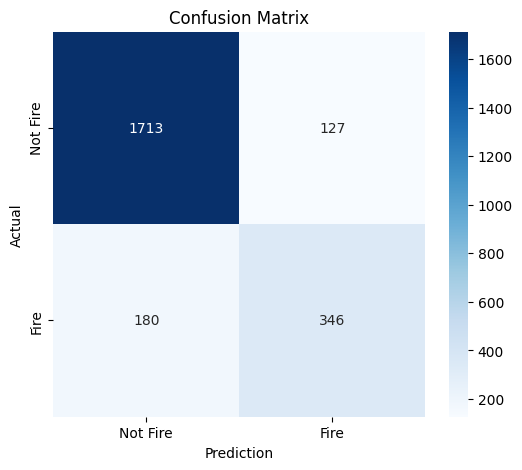

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1️⃣ Load data
# -----------------------------
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/Decision Tree/data_final.gpkg")
df = gdf.drop(columns='geometry')  # ignore geometry
df['fire'] = df['fire'].astype(int)

# One-hot encode GRIDCODE
df_encoded = pd.get_dummies(df, columns=['GRIDCODE'], drop_first=False)

# Split features and target
X = df_encoded.drop(columns=['fire'])
y = df_encoded['fire']

# -----------------------------
# 2️⃣ Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 3️⃣ Random Forest with GridSearchCV
# -----------------------------
rf = RandomForestClassifier(random_state=42, criterion='entropy',max_features= 'sqrt')

# Grid of hyperparameters
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 5, 10, 20],
    'max_samples': [0.5, 0.7, None]        # fraction of rows per tree
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # good for imbalanced datasets
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

# -----------------------------
# 4️⃣ Best hyperparameters
# -----------------------------
print("Best hyperparameters:")
print(grid_search.best_params_)

# -----------------------------
# 5️⃣ Evaluate on test set
# -----------------------------
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n=== TEST METRICS ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred):.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -----------------------------
# 6️⃣ Confusion matrix
# -----------------------------
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['Not Fire', 'Fire']

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
